# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
import idx2numpy
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from six.moves import cPickle as pickle
import tensorflow as tf

import matplotlib.pyplot as plt

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

/Users/yanndupis/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# read data and convert idx file to numpy array

# read train data
train_images = idx2numpy.convert_from_file('./data_step1/train-images-idx3-ubyte.idx')
train_labels = idx2numpy.convert_from_file('./data_step1/train-labels-idx1-ubyte.idx')

# read test data
test_images = idx2numpy.convert_from_file('./data_step1/t10k-images-idx3-ubyte.idx')
test_labels = idx2numpy.convert_from_file('./data_step1/t10k-labels-idx1-ubyte.idx')

The label of this image is: 4


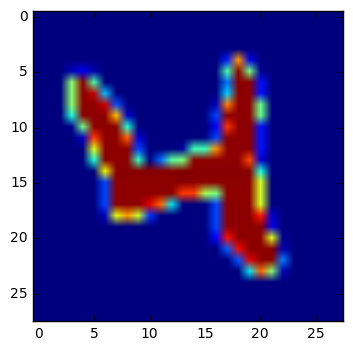

In [3]:
print"The label of this image is:",train_labels[20]
plt.imshow(train_images[20])

In [4]:
image_height = 28
image_width = 140
pixel_depth = 255.0  # Number of levels per pixel.

def createSequences(images,labels):
    
    dataset_size = images.shape[0]/5
    dataset_sequence = np.ndarray(shape=(dataset_size, image_height, image_width),
                         dtype=np.float32)

    data_labels = []
    zeros_mat = np.ones((28,28))
    i = 0
    w = 0
    d=0
    
    while i < dataset_size:
        #Generate sequence of length 1 to 5 digits
        d=random.randint(1,4)
        image_seq = np.hstack([images[w+j] for j in range(d)])
        empty_seq = np.hstack([zeros_mat for j in range(d,5)])
        dataset_sequence[i, :, :] =  np.hstack([image_seq,empty_seq]) 
        labels_seq = [labels[w+j] for j in range(d)]
        #blank characters are represented by the digit 10
        empty_chr =  [10 for j in range(d,5)]
        data_labels.append(labels_seq+empty_chr)
        w += 5
        i += 1
        
    data_labels= np.array(data_labels)
    #Normalized dataset
    dataset_sequence = (dataset_sequence - 
                    pixel_depth / 2) / pixel_depth

    return dataset_sequence, data_labels

In [5]:
train_images_seq, train_labels_seq = createSequences(train_images,train_labels)
test_images_seq, test_labels_seq = createSequences(test_images,test_labels)

print('Training set sequence', train_images_seq.shape, train_labels_seq.shape)
print('Test set sequence', test_images_seq.shape, test_labels_seq.shape)

('Training set sequence', (12000, 28, 140), (12000, 5))
('Test set sequence', (2000, 28, 140), (2000, 5))


Display the second image:


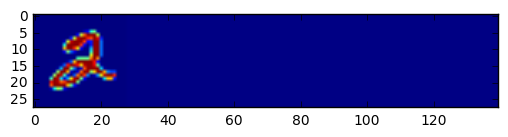

The label associated to the second image is: [ 2 10 10 10 10]

Display the sixth image:


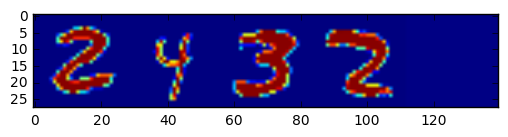

The label associated to the second image is: [ 2  4  3  2 10]


In [6]:
print"Display the second image:"
plt.imshow(train_images_seq[1])
plt.show()
print "The label associated to the second image is:",train_labels_seq[1]
print""
print"Display the sixth image:"
plt.imshow(train_images_seq[5])
plt.show()
print "The label associated to the second image is:",train_labels_seq[5]

Let's flat the reshape the dataset before running the moldel.

In [7]:
image_size = 28
num_labels = 11
num_digits = 5
num_channels=1

def reformat(dataset, labels):
  dataset =  dataset.reshape(
    (-1, image_size, image_size*num_digits, num_channels)).astype(np.float32)
  return dataset, labels

#Reformat the train and test dataset
train_images_seq, train_labels_seq = reformat(train_images_seq, train_labels_seq)
test_dataset, test_labels = reformat(test_images_seq, test_labels_seq)

#Split the train dataset between a train and validation dataset
train_dataset,valid_dataset,train_labels,valid_labels = train_test_split(train_images_seq, train_labels_seq,
                                                                     train_size=0.8,random_state=12343)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (9600, 28, 140, 1), (9600, 5))
('Validation set', (2400, 28, 140, 1), (2400, 5))
('Test set', (2000, 28, 140, 1), (2000, 5))


In [9]:
#Let's create accuracy and softmax function as helper function
def accuracy(predictions, labels):

  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

def softmax(tf_train_labels,logits):
    softmax= tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits) 
    return softmax

In [10]:
image_size = 28
batch_size = 32
patch_size = 5
depth = 16
num_hidden = 64
num_channels=1

graph = tf.Graph()
with graph.as_default():
    
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth*num_digits, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    weights = {
    'wh1': tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1)),
    'wh2': tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1)),
    'wh3': tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth*num_digits, num_hidden], stddev=0.1)),
    'w1': tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1)),
    'w2': tf.Variable(tf.truncated_normal(
      [num_hidden , num_labels], stddev=0.1)),
    'w3': tf.Variable(tf.truncated_normal(
      [num_hidden , num_labels], stddev=0.1)),
    'w4': tf.Variable(tf.truncated_normal(
      [num_hidden , num_labels], stddev=0.1)),
    'w5': tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
    }

    biases = {
        'bh1': tf.Variable(tf.zeros([depth])),
        'bh2': tf.Variable(tf.constant(1.0, shape=[depth])),
        'bh3': tf.Variable(tf.constant(1.0, shape=[num_hidden])),
        'b1': tf.Variable(tf.random_normal([num_labels])),
        'b2': tf.Variable(tf.random_normal([num_labels])),
        'b3': tf.Variable(tf.random_normal([num_labels])),
        'b4': tf.Variable(tf.random_normal([num_labels])),
        'b5': tf.Variable(tf.random_normal([num_labels]))
    }
    
    
    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size*num_digits, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_digits))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    
    def conv_net(tf_dataset, weights, biases):
        
        conv = tf.nn.conv2d(tf_dataset, weights['wh1'], [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + biases['bh1'])
        pooled = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pooled, weights['wh2'], [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + biases['bh2'])
        pooled = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        shape = pooled.get_shape().as_list()
        reshape = tf.reshape(pooled, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, weights['wh3']) + biases['bh3'])
    
        logits1 = tf.matmul(hidden, weights['w1']) + biases['b1']
        logits2 = tf.matmul(hidden, weights['w2']) + biases['b2']
        logits3 = tf.matmul(hidden, weights['w3']) + biases['b3']
        logits4 = tf.matmul(hidden, weights['w4']) + biases['b4']
        logits5 = tf.matmul(hidden, weights['w5']) + biases['b5']

        return logits1,logits2,logits3,logits4,logits5
    
    logits1_train,logits2_train,logits3_train,logits4_train,logits5_train= conv_net(tf_train_dataset, weights, biases)
    logits1_valid,logits2_valid,logits3_valid,logits4_valid,logits5_valid= conv_net(tf_valid_dataset, weights, biases)
    logits1_test,logits2_test,logits3_test,logits4_test,logits5_test= conv_net(tf_test_dataset, weights, biases)
    
    softmax1 = softmax(tf_train_labels[:,0],logits1_train)
    softmax2 = softmax(tf_train_labels[:,1],logits2_train)
    softmax3 = softmax(tf_train_labels[:,2],logits3_train)
    softmax4 = softmax(tf_train_labels[:,3],logits4_train)
    softmax5 = softmax(tf_train_labels[:,4],logits5_train)
    
    loss = tf.reduce_mean(softmax1+softmax2+softmax3+softmax4+softmax5)

    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    
    def prediction(logits1,logits2,logits3,logits4,logits5):
        
        prediction = tf.stack([tf.nn.softmax(logits1),tf.nn.softmax(logits2),
                                tf.nn.softmax(logits3),tf.nn.softmax(logits4),
                                tf.nn.softmax(logits5)])
        return prediction
        
    
    train_prediction = prediction(logits1_train,logits2_train,logits3_train,logits4_train,logits5_train)
    
    valid_prediction = prediction(logits1_valid,logits2_valid,logits3_valid,logits4_valid,logits5_valid)
    
    test_prediction = prediction(logits1_test,logits2_test,logits3_test,logits4_test,logits5_test)

In [11]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 40.969872
Minibatch accuracy: 5.6%
Validation accuracy: 40.9%
Minibatch loss at step 1000: 1.753050
Minibatch accuracy: 86.2%
Validation accuracy: 92.0%
Minibatch loss at step 2000: 0.902541
Minibatch accuracy: 94.4%
Validation accuracy: 94.7%
Minibatch loss at step 3000: 0.546809
Minibatch accuracy: 96.2%
Validation accuracy: 95.8%
Minibatch loss at step 4000: 0.144847
Minibatch accuracy: 99.4%
Validation accuracy: 96.6%
Minibatch loss at step 5000: 0.220518
Minibatch accuracy: 98.1%
Validation accuracy: 96.9%
Minibatch loss at step 6000: 0.144827
Minibatch accuracy: 98.8%
Validation accuracy: 96.9%
Minibatch loss at step 7000: 0.056241
Minibatch accuracy: 100.0%
Validation accuracy: 97.0%
Minibatch loss at step 8000: 0.033190
Minibatch accuracy: 100.0%
Validation accuracy: 97.1%
Minibatch loss at step 9000: 0.067169
Minibatch accuracy: 100.0%
Validation accuracy: 97.3%
Mini

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.